In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords

from bs4 import BeautifulSoup 

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
from time import time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/ideis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv( "data/testData.tsv", header=0, delimiter="\t", quoting=3)

print("Train: %d, Test: %d\n"
      % (train["review"].size, test["review"].size))

Train: 25000, Test: 25000



In [3]:
def clean_text(text, remove_stopwords=True):
    '''Clean the text, with the option to remove stopwords'''
    text = BeautifulSoup(text).get_text()
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    return(text)

def extract_sentiment(s):
    s = re.sub(r"[^0-9]", " ", s)
    n = int(s.split()[1])
    if n <= 5:
        return 0
    else:
        return 1
train['review'] = train.apply(lambda x: clean_text(x['review']), axis=1)
test['review'] = test.apply(lambda x: clean_text(x['review']), axis=1)
test['sentiment'] = test.apply(lambda x: extract_sentiment(x['id']), axis=1)

In [4]:
from gensim.models.word2vec import Word2Vec

word2vec_model = Word2Vec.load("model/word2vec_imdb_reviews_300d.bin")

In [5]:
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in word2vec_model.wv.vocab:
            average = np.add(average, word2vec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [6]:
# Create word vectors
text_dim = 300

data = np.zeros((train.shape[0], text_dim), dtype="float32")
for i in range(len(train['review'])):
    data[i] = create_average_vec(train['review'][i])
    
labels = np.asarray(train["sentiment"])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 300)
Shape of label tensor: (25000,)


In [7]:
data = np.expand_dims(data, axis=2)

In [8]:
training_samples = 20000
validation_samples = 5000

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM, Bidirectional
from keras.optimizers import RMSprop
model = Sequential()
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.5, return_sequences=True),merge_mode='concat',input_shape=(300,1)))
# model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.5, return_sequences=True, input_shape=(300,1)))
# model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 300, 128)          33792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 38401     
Total params: 72,193
Trainable params: 72,193
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_val,y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 114s 6ms/step - loss: 0.6312 - acc: 0.6760 - val_loss: 0.5524 - val_acc: 0.7582
Epoch 2/20
20000/20000 [==============================] - 113s 6ms/step - loss: 0.5332 - acc: 0.7551 - val_loss: 0.4576 - val_acc: 0.8088
Epoch 3/20
20000/20000 [==============================] - 114s 6ms/step - loss: 0.4650 - acc: 0.7935 - val_loss: 0.4151 - val_acc: 0.8230
Epoch 4/20
20000/20000 [==============================] - 115s 6ms/step - loss: 0.4304 - acc: 0.8109 - val_loss: 0.3775 - val_acc: 0.8452
Epoch 5/20
20000/20000 [==============================] - 116s 6ms/step - loss: 0.4079 - acc: 0.8189 - val_loss: 0.3690 - val_acc: 0.8494
Epoch 6/20
20000/20000 [==============================] - 118s 6ms/step - loss: 0.3952 - acc: 0.8303 - val_loss: 0.3524 - val_acc: 0.8604
Epoch 7/20
20000/20000 [==============================] - 122s 6ms/step - loss: 0.3851 - acc: 0.8336 - val_loss: 0.3449 - v

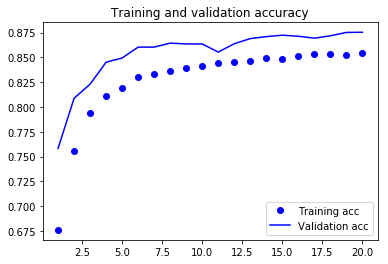

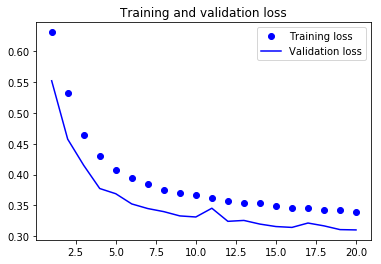

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('lstm-acc-w2v.png')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('lstm-loss-w2v.png')

plt.show()

In [36]:
x_test = np.zeros((test.shape[0], text_dim), dtype="float32")
for i in range(len(test['review'])):
    x_test[i] = create_average_vec(test['review'][i])

y_test = np.asarray(test["sentiment"])
x_test = np.expand_dims(x_test, axis=2)
scores = model.evaluate(x_test, y_test)
print("Accuracy:", scores[1])

25000/25000 [==============================] - 64s 3ms/step
Accuracy: 0.8688


In [38]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(x_test)
print("ROC-AUC:",roc_auc_score(y_test, y_pred))

ROC-AUC: 0.9430318752
